***
## Table of Contents
[Getting the Data](#Getting-the-data)
- [Defining some useful column/feature subsets](#Defining-some-useful-column/feature-subsets)
- [Defining a customizable filter](#Defining-a-customizable-filter)

[A first look at the MegaFile](#A-first-look-at-the-MegaFile)
- [Initial Observations](#Initial-Observations)
- [Obtaining subsets of ABS files](#Obtaining-subsets-of-ABS-files)

[Making Sense of the Columns](#Making-Sense-of-the-Columns)
- [Vehicle Features](#Vehicle-Features)
- [Customer Features](#Vehicle-Features)
- [Contract Features](#Vehicle-Features)

[Repeating AssetNumbers](#Repeating-AssetNumbers)
- [Finding Instances of an AssetNumber across all ABS-EE Files](#Finding-Instances-of-an-Asset_Number-across-all-ABS-EE-Files-(archive))
- [Create History for AssetNumbers with Repeated Instances](#Create-History-for-AssetNumbers-with-Repeated-Instances)
- [AssetNumber Represents a unique Contract](#Asset_Number-Represents-a-unique-Contract)
- [Code Chunk Function: *Create an Annotated Action History For any Given Contract*](#Code-Chunk-Function:-Create-an-Annotated-Action-History-For-any-Given-Contract)
- [Customers Who Broke Their Lease (Inactive Contracts)](#Customers-Who-Broke-Their-Lease-(Inactive-Contracts)) 

[Finding Active Contracts](#Finding-Active-Contracts)
- [Breakdown of Actively Leased Vehicles By Model](#Breakdown-of-Actively-Leased-Vehicles-By-Model)
- [Finding the oldest Bikes being leased at the moment](#Finding-the-oldest-Bikes-being-leased-at-the-moment)
- [Finding Total Value of All Vehicles On Loan](#Finding-Total-Value-of-All-Vehicles-On-Loan)

[Repossessions](#Repossessions)

[Deliquencies](#Deliquencies)
- [Examining the Stories behind Deliquent Contracts](#Examining-the-Stories-behind-Deliquent-Contracts)
- [Deliquency Codes sorted by Hieararchy](#Deliquency-Codes-sorted-by-Hieararchy)
- [Deliquency Codes sorted by Frequency](##Deliquency-Codes-sorted-by-Frequency)

[Examining different contracts associated with the same model](#Examining-different-contracts-associated-with-the-same-model)
- [Do customers with the same credit score who lease the same model receive the same loan?](Do-customers-with-the-same-credit-score-who-lease-the-same-model-receive-the-same-loan?)
- [Query---Same Customer Profile](#Query---Same-Customer-Profile)

[Tracking Exposure History](#Tracking-Exposure-History)
***

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime

# Getting the data 
*Note Download process was imperfect (easy to miss a file)
- Not too lengthy ~ 30 minutes 

We recieve the ABS-EE files in reverse chronological order as shown below. We will 'glue' them end-to-end to create a mega ABS-EE file (which is a Pandas DataFrame). 
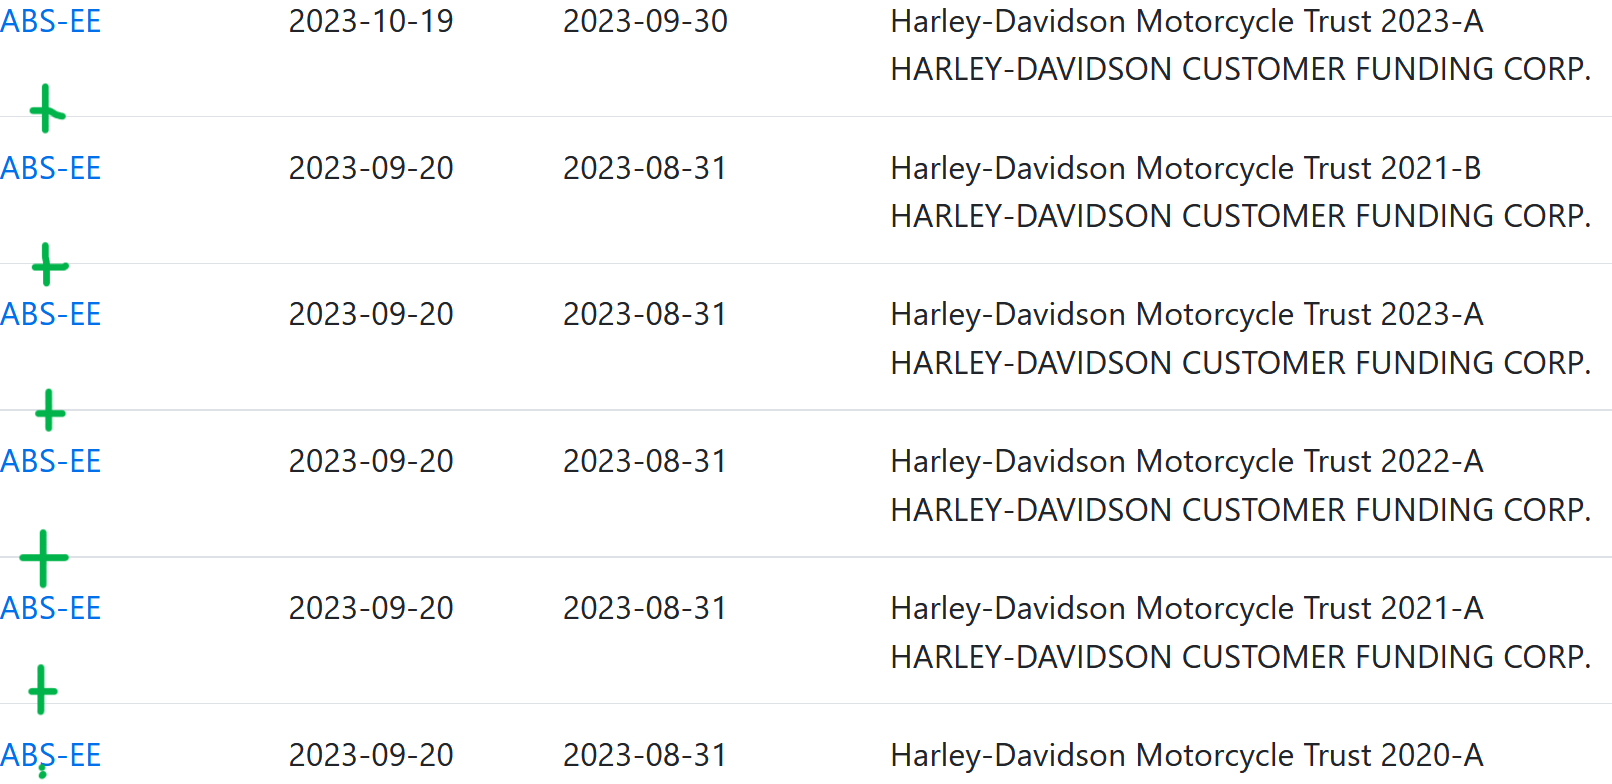
Because this DataFrame contains the entire  (relative) filing history for Harley-Davidson, it serves as our *Archive* of ABS-EE reports 



###  Read Saved ABS-EE megafile
We begin with the Mega File already assembled. That is why it's a simple command to read a (large) csv file. We also make some adjustments. We transform some string dates to Pandas DateTime objects and sort dates in reverse chronological order

In [49]:
loan_features

Index(['actualInterestCollectedAmount', 'actualOtherCollectedAmount',
       'actualPrincipalCollectedAmount', 'assetAddedIndicator', 'assetNumber',
       'assetSubjectDemandIndicator', 'assetTypeNumber',
       'chargedoffPrincipalAmount', 'currentDelinquencyStatus',
       'gracePeriodNumber', 'interestCalculationTypeCode',
       'interestPaidThroughDate', 'loanMaturityDate', 'modificationTypeCode',
       'nextInterestRatePercentage', 'nextReportingPeriodPaymentAmountDue',
       'originalFirstPaymentDate', 'originalInterestRatePercentage',
       'originalInterestRateTypeCode', 'originalLoanAmount',
       'originalLoanTerm', 'originationDate', 'originatorName',
       'otherAssessedUncollectedServicerFeeAmount',
       'otherPrincipalAdjustmentAmount', 'paymentExtendedNumber',
       'paymentTypeCode', 'primaryLoanServicerName', 'recoveredAmount',
       'remainingTermToMaturityNumber',
       'reportingPeriodActualEndBalanceAmount', 'reportingPeriodBeginningDate',
       'repor

In [2]:
df = pd.read_pickle('ABS.csv') #when pd.read_csv takes too long, pd.read_pickle can help

df['reportingPeriodEndingDate'] = df['reportingPeriodEndingDate'].apply(pd.to_datetime) # datimetime conversion
df['originationDate'] = df['originationDate'].apply(pd.to_datetime) # datimetime conversion
archive = df.sort_values(by=['reportingPeriodEndingDate'],ascending=False).reset_index() #most recent files at top

### Assembling MegaFile/Archive from Scratch
I will try to upload a seperate, short notebook for assembling the combined ABS dataframe from individual files.
The function to do so is quite simple, here is the psuedo-code.

--- At this point I have saved all ABS-EE.html files from Sec.gov in a Folder---
```python
def create_megafile(folder):
    folder = 'Harley'
    all_reports = [] 
    for file in folder: 
        single_report = pd.read_xml(file.html) # creates a Pandas DF
        all_reports.append(single_report) # add current ABS-EE file to list
    df = pd.concat(all_reports) # Stack the files vertically, on top of each other
    return df
```

### Defining some useful column/feature subsets
We can use them as filters instead of looking through all columns at once

Each one of the 65 columns is carrying information related to either the *Vehicle*, *Customer* or *Contract*



In [3]:
customer_features = ['obligorCreditScoreType', # I simply copied the desired column names and pasted them here
 'obligorCreditScore',
 'obligorIncomeVerificationLevelCode',
 'obligorEmploymentVerificationCode',
 'coObligorIndicator',
 'paymentToIncomePercentage',
 'obligorGeographicLocation']
vehicle_features= ['vehicleManufacturerName',
 'vehicleModelName',
 'vehicleNewUsedCode',
 'vehicleModelYear',
 'vehicleTypeCode',
 'vehicleValueAmount',
 'vehicleValueSourceCode']
## NOTICE LOAN IS DEFINED AS THE REMAINING COLUMNS (seemed like an simler way than typing out )
loan_features= df.columns.difference(set(customer_features+vehicle_features)) # 50 cols

## Defining a customizable filter
If you imagine somebody signing a lease contract, there's a story that unfolds. Here are some columns which help that tell that story
-      - *reportingPeriodEndingDate*
        TimeStamp for the events taking place (can use 'begindate' too)
-       - *remainingTermToMaturityNumber*
        Time remaining on the lease. If somebody kept their lease to its theoretical end, it would progressively go from from ~60 months to 0 months. At the end, that person would own the vehicle having paid a good bit above the market value. *Does not not seem like this ever happens in practice. Most People break the lease (return the car) after 2 or 3 years
        
        
-       - *zeroBalanceEffectiveDate*
        When the loan has been settled and no more updates for the contract could be expected 

   
- *actualPrincipalCollectedAmount*
- *actualInterestCollectedAmount*
- *actualOtherCollectedAmount*

        The possible payments which may occur at each Timestamp in the story
    
-        - *totalActualAmountPaid*
        Appears to be the sum of the possible paymnents
    
    
- *reportingPeriodBeginningLoanBalanceAmount**
- *reportingPeriodActualEndBalanceAmount**

        When a customer signs a lease, they are recieving a loan. They progressively pay the value of that loan off. Each time they do, their loan balance goes down. We can contextualize the payments occuring at each timestamp with how much their loan balance is.

-        - *currentDelinquencyStatus*
        Associated Deliquency Status for the Timestamp


In [4]:
contract_history_features = ['reportingPeriodEndingDate','remainingTermToMaturityNumber','zeroBalanceEffectiveDate','actualPrincipalCollectedAmount','actualInterestCollectedAmount','totalActualAmountPaid','reportingPeriodBeginningLoanBalanceAmount','reportingPeriodActualEndBalanceAmount','currentDelinquencyStatus']#,'zeroBalanceCod'reportingPeriodBeginningLoanBalanceAmount','reportingPeriodActualEndBalanceAmount','totalActualAmountPaid']

## A first look at the MegaFile

In [5]:
print(f'DataFrame has {archive.shape[0]} Rows and {archive.shape[1]} Columns')
filing_dates = []
for date in archive['reportingPeriodBeginningDate']:
    if date not in filing_dates:
        filing_dates.append(date)
print(f'Most recent 10 filing_dates are {filing_dates[:10]}')
archive

DataFrame has 849759 Rows and 65 Columns
Most recent 10 filing_dates are ['09-01-2023', '08-01-2023', '07-01-2023', '06-01-2023', '03-01-2023', '01-01-2023', '12-01-2022', '08-01-2022', '05-01-2022', '12-01-2021']


,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
0,6759,HDCC,hd9571227178180,09-01-2023,2023-09-30,ESB,2020-05-01,44285.49,86,06/2027,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
1,31144,HDCC,hd9681384859552,09-01-2023,2023-09-30,ESB,2020-07-01,14588.73,85,07/2027,...,0.0,NaN,False,0.1089,09-29-2023,0.0,NaN,NaN,NaN,NaN
2,31146,HDCC,hd9987599108743,09-01-2023,2023-09-30,ESB,2020-07-01,21266.18,61,07/2025,...,0.0,NaN,False,0.0549,09-13-2023,0.0,NaN,NaN,NaN,NaN
3,31147,HDCC,hd9992536846127,09-01-2023,2023-09-30,ESB,2020-07-01,14548.49,85,07/2027,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
4,31148,HDCC,hd9105527196627,09-01-2023,2023-09-30,ESB,2020-07-01,35067.54,85,07/2027,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
849754,12090,HDCC,hd9980529533658,02-01-2020,2020-02-29,ESB,2018-10-01,12359.47,74,11/2024,...,0.0,NaN,False,0.0379,02-07-2020,0.0,NaN,NaN,NaN,NaN
849755,12089,HDCC,hd9965157332370,02-01-2020,2020-02-29,ESB,2018-11-01,18539.85,73,11/2024,...,0.0,NaN,False,0.0849,11-29-2019,0.0,NaN,NaN,NaN,NaN
849756,12088,HDCC,hd9703985649722,02-01-2020,2020-02-29,ESB,2018-10-01,39990.51,74,11/2024,...,0.0,NaN,False,0.0499,02-15-2020,0.0,NaN,NaN,NaN,NaN
849757,12087,HDCC,hd9668937030786,02-01-2020,2020-02-29,ESB,2018-10-01,18014.55,85,10/2025,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN


 ### Initial Observations
1) We have an abundance of columns. Each row/entry has 65 features
   - Making sense of these columns will give us an idea what information the dataframe contains  
   
2) The dataframe's size is pretty big---> ~1 million rows (each with 65 columns!)
   - For looping is not viable
      - Pandas (2,500 times faster) has extensive DataFrame Manipulation library

         
Why not download the few, recent & relevant reports? (cuts down data size & circumvents issue)
- Having an Archive will allow us to pull current and *historical* data  



### Obtaining subsets of ABS files
 If we want a subset of relevant reports, they can be accessed from the Archive DataFrame by specifying the starting and ending dates for the timespan.

The following is a code chunk that acts as a function for finding relevant reports.

In [6]:
start = '2021-06-15' # Input any date
end = '2023-02-20'   # Input any later date

In [7]:
r_filing = filing_dates.copy() # The list of all unique filing dates (reverse chron)
r_filing.reverse() # we apply the reverse method so reverse_filing contains dates in chronological order

# To document later 
start_date = datetime.strptime(start, '%Y-%m-%d').date()
end_date = datetime.strptime(end, '%Y-%m-%d').date()
first_file_date = [x for x in r_filing if datetime.strptime(x, '%m-%d-%Y').date() >= start_date][0]
second_file_date = [x for x in filing_dates if datetime.strptime(x, '%m-%d-%Y').date() <= end_date][0]
d1 = first_file_date.split('-')
date1 = '-'.join([d1[0],d1[1],d1[2]])
d2 = second_file_date.split('-')
date2 = '-'.join([d2[0],d2[1],d2[2]])
start_index = archive[archive['reportingPeriodBeginningDate'] == date1].index 
end_index = archive[archive['reportingPeriodBeginningDate'] == date2].index

# We do all this to get 'relevant_reports' below
relevant_reports = archive.copy().iloc[end_index[0]:start_index[-1],:]

# not super imortant but annoying DateTime Format Conversion
dd1 = date1.split('-')
ddate1 = '-'.join([dd1[2],dd1[0],dd1[1]])
dd2 = date2.split('-')
ddate2 = '-'.join([dd2[2],dd2[0],dd2[1]])
print(f'Closest Report equal or Past Cutoff {start} --> {ddate1} Report')
print(f'Closest Report equal or Before Cutoff {end} --> {ddate2} Report')
relevant_reports

Closest Report equal or Past Cutoff 2021-06-15 --> 2021-08-01 Report
Closest Report equal or Before Cutoff 2023-02-20 --> 2023-01-01 Report


,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
528015,17768,HDCC,hd9348680521552,01-01-2023,2023-01-31,ESB,2017-10-01,38428.95,61,02/2023,...,0.0,NaN,False,0.0799,01-07-2023,4.0,NaN,NaN,NaN,NaN
528016,17766,HDCC,hd9457195731234,01-01-2023,2023-01-31,ESB,2017-07-01,22501.84,61,10/2022,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
528017,17767,HDCC,hd9751468338531,01-01-2023,2023-01-31,ESB,2017-09-01,45430.54,88,04/2025,...,0.0,NaN,False,0.0775,01-27-2023,0.0,NaN,NaN,NaN,NaN
528018,17773,HDCC,hd9515089151053,01-01-2023,2023-01-31,ESB,2018-09-01,26485.90,74,12/2024,...,0.0,NaN,False,0.0699,01-27-2023,60.0,NaN,NaN,NaN,NaN
528019,17769,HDCC,hd9953438508011,01-01-2023,2023-01-31,ESB,2017-11-01,7140.80,61,03/2023,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
813460,24198,HDCC,hd9892904301296,08-01-2021,2021-08-31,ESB,2019-06-01,21350.86,61,06/2024,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
813461,24197,HDCC,hd9703052957612,08-01-2021,2021-08-31,ESB,2019-06-01,43346.46,85,06/2026,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
813462,24196,HDCC,hd9701506420998,08-01-2021,2021-08-31,ESB,2019-06-01,27304.54,73,06/2025,...,0.0,NaN,False,0.0599,08-01-2021,0.0,NaN,NaN,NaN,NaN
813463,24195,HDCC,hd9693382445529,08-01-2021,2021-08-31,ESB,2019-06-01,36598.01,85,06/2026,...,0.0,NaN,False,0.1095,08-27-2021,0.0,NaN,NaN,NaN,NaN


# Making Sense of the Columns

1) we have features related to the **customer** (location,credit score, etc)

2) we have features related to the **vehicle** (model,value,etc)

3) We have features related to the **contract** (loan amount,interest_rate,etc)


So for each row in the mega ABS-EE file, 'archive' , the 65 columns have information about the customer,vehicle, or contract

In [8]:
archive.head(3) # first 3 rows of megafile

,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
0,6759,HDCC,hd9571227178180,09-01-2023,2023-09-30,ESB,2020-05-01,44285.49,86,06/2027,...,0.0,0.0,False,NaN,None,NaN,NaN,NaN,NaN,NaN
1,31144,HDCC,hd9681384859552,09-01-2023,2023-09-30,ESB,2020-07-01,14588.73,85,07/2027,...,0.0,NaN,False,0.1089,09-29-2023,0.0,NaN,NaN,NaN,NaN
2,31146,HDCC,hd9987599108743,09-01-2023,2023-09-30,ESB,2020-07-01,21266.18,61,07/2025,...,0.0,NaN,False,0.0549,09-13-2023,0.0,NaN,NaN,NaN,NaN


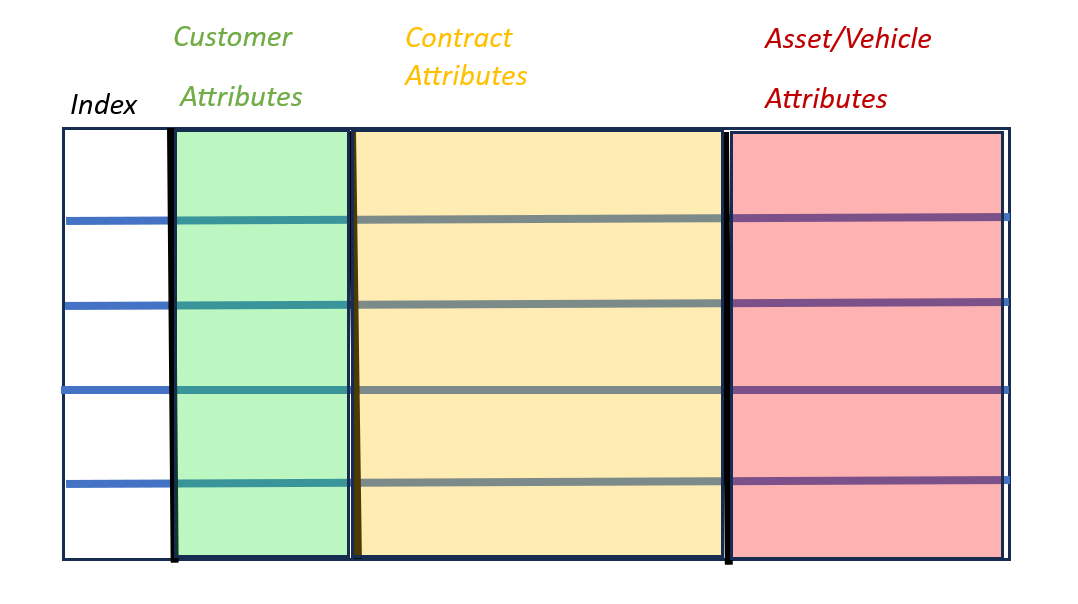

# Vehicle Features

In [9]:
archive[vehicle_features].head(7) # First Seven Rows of archive but just the vehicle features

,vehicleManufacturerName,vehicleModelName,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,vehicleValueSourceCode
0,HARLEY-DAVIDSON,FLTRXS ROAD GLIDE SPECIAL,1,2020.0,4,30578.0,98
1,HARLEY-DAVIDSON,XL1200NS IRON 1200,1,2020.0,4,10998.0,98
2,HARLEY-DAVIDSON,FXLRS LOW RIDER S,1,2020.0,4,19798.0,98
3,HARLEY-DAVIDSON,XL1200X FORTY-EIGHT,1,2020.0,4,12813.0,98
4,HARLEY-DAVIDSON,FLHRXS ROAD KING SPECIAL,1,2020.0,4,25793.0,98
5,HARLEY-DAVIDSON,FLSTC HERITAGE SOFTAIL CLASSIC,2,2013.0,4,10560.0,98
6,HARLEY-DAVIDSON,FLHXS STREET GLIDE SPECIAL,1,2020.0,4,31018.0,98


# Customer Features

In [10]:
archive[customer_features].head(7) #First Seven Rows of archive but just the customer features

,obligorCreditScoreType,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation
0,Credit Bureau,773,2,2,False,0.1293,CA
1,Credit Bureau,794,2,2,True,0.0187,CO
2,Credit Bureau,790,2,2,False,0.0812,VA
3,Credit Bureau,701,2,2,True,0.0163,NC
4,Credit Bureau,720,2,2,False,0.0903,TN
5,Credit Bureau,712,3,2,True,0.0667,IN
6,Credit Bureau,711,2,2,False,0.0469,NH


# Loan Features
Information related to the contract itself make up the bulk of features ~ 50 columns

In [11]:
archive[loan_features].head(7)

,actualInterestCollectedAmount,actualOtherCollectedAmount,actualPrincipalCollectedAmount,assetAddedIndicator,assetNumber,assetSubjectDemandIndicator,assetTypeNumber,chargedoffPrincipalAmount,currentDelinquencyStatus,gracePeriodNumber,...,scheduledInterestAmount,scheduledPrincipalAmount,servicerAdvancedAmount,servicingAdvanceMethodCode,servicingFeePercentage,subvented,totalActualAmountPaid,underwritingIndicator,zeroBalanceCode,zeroBalanceEffectiveDate
0,0.00,0.0,0.00,False,hd9571227178180,False,HDCC,0.0,NaN,2,...,0.00,0.00,0.0,2,0.01,0,0.00,True,1.0,04/2021
1,153.24,0.0,342.76,False,hd9681384859552,False,HDCC,NaN,0.0,1,...,86.13,162.82,0.0,2,0.01,0,496.00,True,NaN,None
2,41.24,0.0,364.87,False,hd9987599108743,False,HDCC,NaN,0.0,1,...,40.47,365.64,0.0,2,0.01,0,406.11,True,NaN,None
3,0.00,0.0,0.00,False,hd9992536846127,False,HDCC,0.0,NaN,1,...,0.00,0.00,0.0,2,0.01,0,0.00,True,1.0,05/2022
4,0.00,0.0,0.00,False,hd9105527196627,False,HDCC,0.0,NaN,1,...,0.00,0.00,0.0,2,0.01,0,0.00,False,1.0,09/2022
5,0.00,0.0,0.00,False,hd9111974204682,False,HDCC,0.0,NaN,1,...,0.00,0.00,0.0,2,0.01,0,0.00,False,4.0,09/2021
6,0.00,0.0,0.00,False,hd9279987706518,False,HDCC,0.0,NaN,1,...,0.00,0.00,0.0,2,0.01,0,0.00,True,1.0,08/2023


# Repeating AssetNumbers


### Finding Instances of an Asset_Number across all ABS-EE Files (archive)

In [12]:
print(f"How many recorded instances of Asset_Numbers appear across all ABS-EE files (including repeats)? {len(archive['assetNumber'])}") # 
print(f"NUMBER OF UNIQUE ASSET_NUMBERS (not including repeats) = {len(set((archive['assetNumber'])))}")
print(f"There are {len(archive['assetNumber'])-len(set((archive['assetNumber'])))} AssetNumbers that appear multiple times")

How many recorded instances of Asset_Numbers appear across all ABS-EE files (including repeats)? 849759
NUMBER OF UNIQUE ASSET_NUMBERS (not including repeats) = 199700
There are 650059 AssetNumbers that appear multiple times


In [13]:
asset_ids_that_repeat = [x.strip() for x in open("IDS.txt").readlines()] # already prepared a list af repeats to test

In [14]:
asset_ids_that_repeat[0] # example of an asset_number that repeats

'hd9388552157088'

## Create History for AssetNumbers with Repeated Instances

#### From an initial (larger) DataFrame, Create a Slice where all rows contain the same asset number
Because we're using archive, the resulting mini dataframe will resemble a sequence of actions for the asset_number
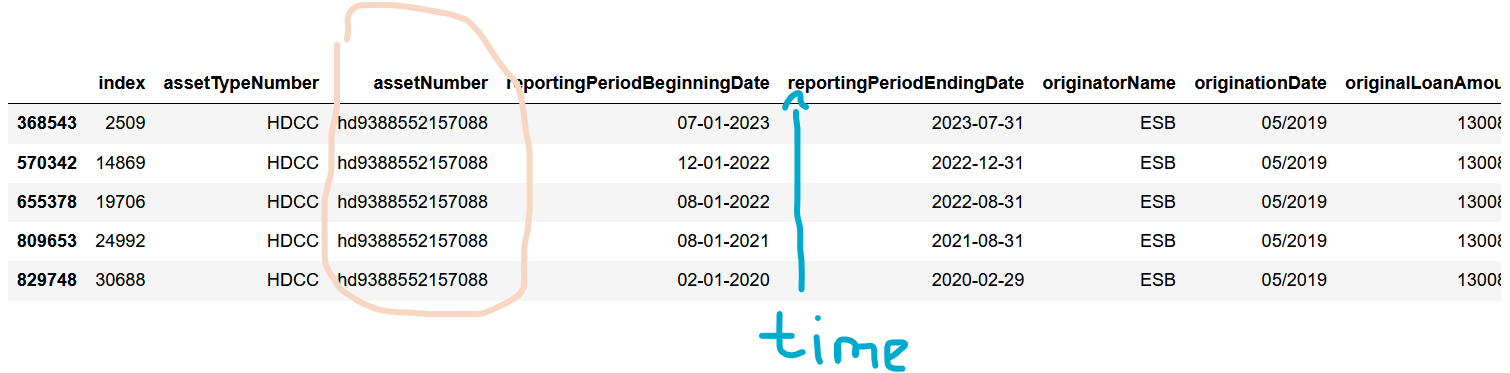

## Asset_Number Represents a unique Contract
We can find this from the slice of repeating asset_numbers. If we look at the Vehicle_Features and Customer_Features together, it seems like it is a single customer and vehicle.

*Note the customer_feature are columns furthest right on the dataframe below and can be accessed by hovering over it & scrolling 

In [15]:
tag = asset_ids_that_repeat[0]
archive[archive['assetNumber']==tag].copy()[['assetNumber']+customer_features + vehicle_features]

,assetNumber,obligorCreditScoreType,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,vehicleManufacturerName,vehicleModelName,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,vehicleValueSourceCode
368543,hd9388552157088,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98
570342,hd9388552157088,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98
655378,hd9388552157088,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98
809653,hd9388552157088,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98
829748,hd9388552157088,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98


In [16]:
archive[archive['assetNumber']==tag].copy()[customer_features + vehicle_features].drop_duplicates()

,obligorCreditScoreType,obligorCreditScore,obligorIncomeVerificationLevelCode,obligorEmploymentVerificationCode,coObligorIndicator,paymentToIncomePercentage,obligorGeographicLocation,vehicleManufacturerName,vehicleModelName,vehicleNewUsedCode,vehicleModelYear,vehicleTypeCode,vehicleValueAmount,vehicleValueSourceCode
368543,Credit Bureau,733,2,2,False,0.0608,IA,HARLEY-DAVIDSON,FLSTSB CROSS BONES,2,2011.0,4,11915.0,98


#### In other words, this slice represents a *timeline* of the loan contract for a given asset_number
To make this more apparent, I will look at the same slice/ mini-DataFrame with our special filter.

We can begin to see it may belong to a customer who has kept their lease active as far back as our history goes. 
(They pay in five installments of $250)  


In [17]:
archive[archive['assetNumber']==tag].copy()[contract_history_features]

,reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
368543,2023-07-31,22.0,None,223.00,27.00,250.0,3627.30,3404.30,0.0
570342,2022-12-31,29.0,None,212.65,37.35,250.0,5170.05,4957.40,0.0
655378,2022-08-31,33.0,None,213.10,36.90,250.0,6020.19,5807.09,0.0
809653,2021-08-31,45.0,None,200.35,49.65,250.0,8400.20,8199.85,0.0
829748,2020-02-29,63.0,None,179.19,70.81,250.0,11552.33,11373.14,0.0


If we rearrange the slice a bit more, we can clearly see this. 
I have stuffed all of the important customer and vehicle information by the upper left.
- (1) Year + Model
- (2) Market Value
- (3) Original Loan Amount
- (4) Payment-To-Income Percentage (% of customer income the lease payments are)
- (5) Interest Rate (at origination date)
- (6) Customer Credit Score (Type == Credit Bureau)
- (7) The TimeSpan From Origination Date to Loan Maturity Date 

Lastly, I placed a self-made column at the very beginning that tracks the total running amount a customer has paid during the lifetime of this lease (initial first payment and subsequent Principal + Interest). While explorations of this type (tracking the money paid by a customer over the course of a contract's lifetime) are of interest, the method behind creating this inferred columns is simple and not reliable for unusual stuff like non-paymnets and payments via repossesion, repurchasing, etc. Even the column 'Actualothercollected', while hardly used is a form of payment which this column misses. In general, though, it can be found from:
1) Original Loan Amount

2) Inital Recorded Balance --> 'reportingPeriodBeginningLoanBalanceAmount' for the initial report filing
```
Running total = (Original Loan Amount) - (Inital Recorded Balance) = Downpayment
```
Then for each report afterwards we just compare the end_balance for the filing to the original loan amount
```
Running total = (Original Loan Amount) - ('reportingPeriodBeginningLoanBalanceAmount)
```


### Code Chunk Function: Create an Annotated Action History For any Given Contract
Have yet to go through code for documenting

In [18]:
# Input of Function
tag = asset_ids_that_repeat[0]

In [19]:
history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['*running_total_paid*(inferred)']+contract_history_features]

,*running_total_paid*(inferred),reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
2011_FLSTSB CROSS BONES Market_Value_11915_USD// LOAN_AMOUNT_$13008 Interest_Rate_7.99% CreditScore_733 Payment_to_Income 6.08% Orgination_Date_To_Maturity 2019-05-01---05/2025,,,,,,,,,,
Asset_Id #hd9388552157088,9603.70,2023-07-01,22.0,None,223.00,27.00,250.0,3627.30,3404.30,0.0
Asset_Id #hd9388552157088,8050.60,2022-12-01,29.0,None,212.65,37.35,250.0,5170.05,4957.40,0.0
Asset_Id #hd9388552157088,7200.91,2022-08-01,33.0,None,213.10,36.90,250.0,6020.19,5807.09,0.0
Asset_Id #hd9388552157088,4808.15,2021-08-01,45.0,None,200.35,49.65,250.0,8400.20,8199.85,0.0
Asset_Id #hd9388552157088,1634.86,2020-02-01,63.0,None,179.19,70.81,250.0,11552.33,11373.14,0.0


## Customers Who Broke Their Lease (Inactive Contracts) 

In This Case, We can see a customer Rented a 2007 Softail for about 2 years before returning it. They paid $4,317.18 by the end of their lease and was never deliquent.

Importantly, the slice shows the contract is no longer active and that the vehicle is not being loaned (in regards to that specific loan contract/ asset_number). We can see this from some of the other columns,(remainingTermToMaturityNumber, amounts paid, etc.) but the column 'zeroBalanceEffectiveDate' tells us directly by changing from 'None' to  the date the contract was no longer active. 

Given this, we should have the ability to track how many vehicles are being loaned at the present moment of inquiry, but also what the circulation of vehicles has been like in the past. 


In [20]:
tag = asset_ids_that_repeat[1] # TESTING A NEW CONTRACT
history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['*running_total_paid*(inferred)']+contract_history_features]

,*running_total_paid*(inferred),reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
2007_FXST SOFTAIL Market_Value_6605_USD// LOAN_AMOUNT_$8255 Interest_Rate_8.19% CreditScore_746 Payment_to_Income 5.6% Orgination_Date_To_Maturity 2019-02-01---02/2025,,,,,,,,,,
Asset_Id #hd9591986817145,0.00,2023-07-01,0.0,10/2022,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9591986817145,0.00,2022-12-01,0.0,10/2022,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9591986817145,4317.18,2022-08-01,30.0,None,117.31,28.21,145.52,4055.79,3938.48,0.0
Asset_Id #hd9591986817145,2954.73,2021-08-01,42.0,None,107.90,37.62,145.52,5408.83,5300.93,0.0
Asset_Id #hd9591986817145,1107.75,2020-02-01,60.0,None,95.14,50.38,145.52,7243.05,7147.91,0.0


### A few more examples

Below is an Inactive Contract. Customer Paid $9,500 for an expensive motorcle from winter 2021 to summer 2023 

When a contract is no longer active, Deliqeuncy_Status (furthest column on right) becomes NaN

In [21]:
tag = asset_ids_that_repeat[2]
history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['*running_total_paid*(inferred)']+contract_history_features]

,*running_total_paid*(inferred),reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
2021_FLTRXS ROAD GLIDE SPECIAL Market_Value_29918_USD// LOAN_AMOUNT_$27773 Interest_Rate_3.99% CreditScore_741 Payment_to_Income 7.67% Orgination_Date_To_Maturity 2021-05-01---05/2026,,,,,,,,,,
Asset_Id #hd9181478689248,0.00,2023-09-01,0.0,07/2023,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9181478689248,0.00,2023-08-01,0.0,07/2023,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9181478689248,0.00,2023-07-01,0.0,07/2023,16864.87,57.10,16921.97,16864.87,0.00,NaN
Asset_Id #hd9181478689248,9553.08,2023-03-01,38.0,None,454.20,57.16,511.36,18674.44,18220.24,0.0
Asset_Id #hd9181478689248,5126.87,2022-05-01,48.0,None,435.66,75.70,511.36,23082.11,22646.45,0.0
Asset_Id #hd9181478689248,2112.45,2021-10-01,55.0,None,425.81,85.55,511.36,26086.68,25660.87,0.0


Active Contract for same expensive model (different year). They pay double the interest rate and their CC is 30 points lower

In [22]:
history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['*running_total_paid*(inferred)']+contract_history_features]

,*running_total_paid*(inferred),reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
2021_FLTRXS ROAD GLIDE SPECIAL Market_Value_29918_USD// LOAN_AMOUNT_$27773 Interest_Rate_3.99% CreditScore_741 Payment_to_Income 7.67% Orgination_Date_To_Maturity 2021-05-01---05/2026,,,,,,,,,,
Asset_Id #hd9181478689248,0.00,2023-09-01,0.0,07/2023,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9181478689248,0.00,2023-08-01,0.0,07/2023,0.00,0.00,0.00,0.00,0.00,NaN
Asset_Id #hd9181478689248,0.00,2023-07-01,0.0,07/2023,16864.87,57.10,16921.97,16864.87,0.00,NaN
Asset_Id #hd9181478689248,9553.08,2023-03-01,38.0,None,454.20,57.16,511.36,18674.44,18220.24,0.0
Asset_Id #hd9181478689248,5126.87,2022-05-01,48.0,None,435.66,75.70,511.36,23082.11,22646.45,0.0
Asset_Id #hd9181478689248,2112.45,2021-10-01,55.0,None,425.81,85.55,511.36,26086.68,25660.87,0.0


Quick Note:
Although I have not discussed AssetNumber's which show up once, it is because they seem to simply be initial filing reports. Although it would make sense for them to be active, we will also check their direct activity status before considering them as well.

# Finding Active Contracts 
Each Contract has one vehicle (and customer) associated with it. 

The set of active contracts from the downloaded ABS-EE files represent all the vehicles currently on loan


Finding the active contracts from the Archive_df amounts to selecting contracts/asset_numbers whose who have an open entry in 'zeroBalanceEffectiveDate'.
- For each active contract, we'll take the most recent filing report as it's representative

In [23]:
archive['originationDate'] = archive['originationDate'].apply(pd.to_datetime)
most_current_filings = archive.drop_duplicates('assetNumber',keep='first') # Dropping less recent updates
actives = most_current_filings[most_current_filings['zeroBalanceEffectiveDate'].isnull()] # Filtering for only active loans

print(f"There are  {actives.shape[0]} Active Contracts (rows). Each Row represents a vehicle currently on loan")
print(f"Total number of unique Contracts in all downloaded ABS-EE files = {len(set((archive['assetNumber'])))}")
actives[['assetNumber']+contract_history_features] # All of vehivles on-loan

There are  118325 Active Contracts (rows). Each Row represents a vehicle currently on loan
Total number of unique Contracts in all downloaded ABS-EE files = 199700


,assetNumber,reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
1,hd9681384859552,2023-09-30,46.0,None,342.76,153.24,496.00,9231.21,8888.45,0.0
2,hd9987599108743,2023-09-30,22.0,None,364.87,41.24,406.11,8845.52,8480.65,0.0
8,hd9316880989609,2023-09-30,34.0,None,273.27,81.73,355.00,10750.55,10477.28,0.0
11,hd9478615180130,2023-09-30,24.0,None,160.69,39.31,200.00,4679.73,4519.04,0.0
14,hd9666342365556,2023-09-30,34.0,None,172.74,33.26,206.00,6472.24,6299.50,0.0
...,...,...,...,...,...,...,...,...,...,...
427001,hd9623100439771,2023-07-31,9.0,None,418.63,13.99,432.62,4412.97,3994.34,0.0
427002,hd9758692571152,2023-07-31,29.0,None,286.74,83.26,370.00,9336.74,9050.00,0.0
427005,hd9992182333988,2023-07-31,30.0,None,506.85,121.21,628.06,13925.39,13418.54,0.0
691205,hd9582808570989,2022-05-31,48.0,None,0.00,0.00,0.00,7115.88,7115.88,43.0


###  Breakdown of Actively Leased Vehicles By Model
I stopped at the 20th most leased model, but the list goes down to 1

In [24]:
vehicle_counts = actives.groupby(['vehicleModelName']).count().sort_values('index',ascending=False)
vehicle_counts.rename({'index':'Number On Loan'},axis=1,inplace=True)
vehicle_counts.loc[:,'Number On Loan':'Number On Loan'][:20]

,Number On Loan
vehicleModelName,
FLHXS STREET GLIDE SPECIAL,11204
FLTRXS ROAD GLIDE SPECIAL,11086
FLHX STREET GLIDE,6566
FLHTK ULTRA LIMITED,5070
FXLRS LOW RIDER S,3898
XL883N IRON 883,3699
FLTRX ROAD GLIDE,3558
FLTRK ROAD GLIDE LIMITED,3198
FXBBS STREET BOB 114,2645


###  Finding the oldest Bikes being leased at the moment

First, find oldest Bike Amongst the active contracts

In [25]:
print([x for x in set(actives['vehicleModelYear'])][:10]) # 10 oldest model years

[1972.0, 1975.0, 1976.0, 1977.0, 1979.0, 1980.0, 1981.0, 1982.0, 1983.0, 1984.0]


In [26]:
# Then, choose the oldest date, and find the subset of bikes with that yeat
actives[actives['vehicleModelYear'] == 1972]

,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
29301,12445,HDCC,hd9431379451532,09-01-2023,2023-09-30,ESB,2022-07-01,13746.6,73,07/2028,...,0.0,NaN,False,0.0725,09-01-2023,0.0,NaN,NaN,NaN,NaN


Pass the AssetNumber (our ID) in to the contract history code chunk/ 'function' 

In [27]:
print(actives[actives['vehicleModelYear'] == 1972]['assetNumber'].values[0] == 'hd9431379451532')
tag = 'hd9431379451532'

True


In [28]:
history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['*running_total_paid*(inferred)']+contract_history_features]

,*running_total_paid*(inferred),reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
1972_FLH 74CI Market_Value_11825_USD// LOAN_AMOUNT_$13746 Interest_Rate_7.25% CreditScore_802 Payment_to_Income 6.4% Orgination_Date_To_Maturity 2022-07-01---07/2028,,,,,,,,,,
Asset_Id #hd9431379451532,2271.43,2023-09-01,58.0,None,164.96,71.67,236.63,11640.13,11475.17,0.0
Asset_Id #hd9431379451532,1942.52,2023-07-01,60.0,None,165.31,71.32,236.63,11969.39,11804.08,0.0


# Finding Total Value of All Vehicles On Loan
Discussion on historical exposure is further below. Here we conentrate on finding the total value of vehicles currently being leased. The assumption is that only contracts which are active represent vehicles on-loan. 

Each contract has one customer party and a vehicle.

In [29]:
print(f"Market Value of all Bikes on loan is ${sum(actives['vehicleValueAmount'].values)}")
actives[['assetNumber','vehicleModelName','vehicleValueAmount']] 


Market Value of all Bikes on loan is $2691256871.73


,assetNumber,vehicleModelName,vehicleValueAmount
1,hd9681384859552,XL1200NS IRON 1200,10998.0
2,hd9987599108743,FXLRS LOW RIDER S,19798.0
8,hd9316880989609,FLHRXS ROAD KING SPECIAL,19490.0
11,hd9478615180130,XL883N IRON 883,9898.0
14,hd9666342365556,XL883N IRON 883,9445.0
...,...,...,...
427001,hd9623100439771,FLHRXS ROAD KING SPECIAL,24694.0
427002,hd9758692571152,FLFBS FAT BOY 114,23319.0
427005,hd9992182333988,FLTRXS ROAD GLIDE SPECIAL,29479.0
691205,hd9582808570989,FLHT ELECTRA GLIDE,6285.0


## Reposessions
We can find all (active) contracts where the vehicle has a repossesion indicator of True

We can look at the action history for a randomly selected repo contract to confirm

In [30]:
repos = actives[actives['repossessedIndicator'] == True]
print(f'Number of Repossesed Vehicles from 118k active contracts = {repos.shape[0]}')
repos

Number of Repossesed Vehicles from 118k active contracts = 79


,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
4008,29876,HDCC,hd9963147529110,09-01-2023,2023-09-30,ESB,2020-08-01,40718.84,74,11/2026,...,0.0,NaN,True,0.0399,09-05-2023,44.0,NaN,NaN,NaN,NaN
13689,27899,HDCC,hd9391046910960,09-01-2023,2023-09-30,ESB,2020-06-01,15616.00,85,06/2027,...,0.0,NaN,True,0.0949,07-19-2023,41.0,NaN,NaN,NaN,NaN
14697,24936,HDCC,hd9246783751735,09-01-2023,2023-09-30,ESB,2020-07-01,36679.81,85,09/2027,...,0.0,NaN,True,0.1019,05-23-2023,109.0,NaN,NaN,NaN,NaN
15582,24584,HDCC,hd9498633242299,09-01-2023,2023-09-30,ESB,2020-08-01,32581.25,85,10/2027,...,0.0,NaN,True,0.0819,06-14-2023,76.0,NaN,NaN,NaN,NaN
17228,8889,HDCC,hd9166670108565,09-01-2023,2023-09-30,ESB,2022-05-01,34942.44,85,06/2029,...,0.0,NaN,True,0.1095,07-25-2023,47.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148074,17024,HDCC,hd9159745598840,09-01-2023,2023-09-30,ESB,2023-04-01,17020.27,86,05/2030,...,0.0,NaN,True,0.1444,07-27-2023,51.0,NaN,NaN,NaN,NaN
150077,29943,HDCC,hd9912605701451,09-01-2023,2023-09-30,ESB,2023-05-01,25727.85,86,06/2030,...,0.0,NaN,True,0.1154,07-16-2023,51.0,NaN,NaN,NaN,NaN
150807,29276,HDCC,hd9991856755249,09-01-2023,2023-09-30,ESB,2022-10-01,46426.36,85,10/2029,...,0.0,NaN,True,0.1199,07-24-2023,36.0,NaN,NaN,NaN,NaN
157663,18489,HDCC,hd9178639431696,09-01-2023,2023-09-30,ESB,2023-04-01,13730.67,86,05/2030,...,0.0,NaN,True,0.1604,06-27-2023,51.0,NaN,NaN,NaN,NaN


In [31]:
repos['assetNumber']# draw random contracts as test subject

4008      hd9963147529110
13689     hd9391046910960
14697     hd9246783751735
15582     hd9498633242299
17228     hd9166670108565
               ...       
148074    hd9159745598840
150077    hd9912605701451
150807    hd9991856755249
157663    hd9178639431696
410365    hd9782347502090
Name: assetNumber, Length: 79, dtype: object

In [32]:
# pass ID in to History Function
tag = repos['assetNumber'].values[2]

history = archive[archive['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history[['repossessedIndicator']+contract_history_features]

,repossessedIndicator,reportingPeriodEndingDate,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,totalActualAmountPaid,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount,currentDelinquencyStatus
2020_FLHXS STREET GLIDE SPECIAL Market_Value_31018_USD// LOAN_AMOUNT_$36679 Interest_Rate_10.19% CreditScore_741 Payment_to_Income 7.66% Orgination_Date_To_Maturity 2020-07-01---09/2027,,,,,,,,,,
Asset_Id #hd9246783751735,True,2023-09-01,48.0,None,0.00,0.00,0.00,26205.49,26205.49,109.0
Asset_Id #hd9246783751735,False,2023-07-01,50.0,None,0.00,0.00,0.00,26205.49,26205.49,48.0
Asset_Id #hd9246783751735,False,2023-06-01,51.0,None,0.00,0.00,0.00,26205.49,26205.49,17.0
Asset_Id #hd9246783751735,False,2023-01-01,55.0,None,359.04,253.50,612.54,27516.18,27157.14,0.0
Asset_Id #hd9246783751735,False,2022-08-01,60.0,None,342.17,270.37,612.54,29346.57,29004.40,0.0
Asset_Id #hd9246783751735,False,2021-12-01,67.0,None,340.20,272.34,612.54,31468.04,31127.84,0.0


# Deliquencies
We can find Deliquent Contract in a similar way. From the 118,000 active contracts, about 9k are deliquent. However, deliqeuncy status is not neccesarily indicative of a net debt. It seems to be triggered if a customer pays less than the expected payment.

In [33]:
actives_copy = actives.copy()
deliquents = actives_copy[actives_copy['currentDelinquencyStatus'] != 0.0]

contract_history_features = ['totalActualAmountPaid', # Unrelated, Please Ignore
 'remainingTermToMaturityNumber',
 'zeroBalanceEffectiveDate',
 'actualPrincipalCollectedAmount',
 'actualInterestCollectedAmount',
 'reportingPeriodBeginningLoanBalanceAmount',
 'reportingPeriodActualEndBalanceAmount',
 'currentDelinquencyStatus']
more_features = ['scheduledInterestAmount', 'scheduledPrincipalAmount','reportingPeriodScheduledPaymentAmount','nextReportingPeriodPaymentAmountDue']

In [34]:
# This DataFrame only Contains Active Contracts which are also deliquents
deliquents

,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repurchaseAmount,chargedoffPrincipalAmount,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber
17,31161,HDCC,hd9811586376048,09-01-2023,2023-09-30,ESB,2020-07-01,25970.14,73,07/2026,...,0.0,NaN,False,0.0605,08-30-2023,1.0,NaN,NaN,NaN,NaN
89,31232,HDCC,hd9152303779923,09-01-2023,2023-09-30,ESB,2020-08-01,13791.04,61,08/2025,...,0.0,NaN,False,0.0899,07-28-2023,65.0,NaN,NaN,NaN,NaN
93,31236,HDCC,hd9647176863570,09-01-2023,2023-09-30,ESB,2020-08-01,6834.90,61,08/2025,...,0.0,NaN,False,0.0899,09-14-2023,1.0,NaN,NaN,NaN,NaN
136,31018,HDCC,hd9605996302548,09-01-2023,2023-09-30,ESB,2020-05-01,10361.78,74,08/2026,...,0.0,NaN,False,0.1085,08-13-2023,24.0,NaN,NaN,NaN,NaN
149,31031,HDCC,hd9839672394631,09-01-2023,2023-09-30,ESB,2020-05-01,17516.00,73,05/2026,...,0.0,NaN,False,0.0899,09-12-2023,10.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426633,937,HDCC,hd9882308956535,07-01-2023,2023-07-31,ESB,2019-08-01,12089.00,61,08/2024,...,0.0,NaN,False,0.0875,06-22-2023,16.0,NaN,NaN,NaN,NaN
426660,1016,HDCC,hd9711897215651,07-01-2023,2023-07-31,ESB,2018-03-01,18824.28,85,03/2025,...,0.0,NaN,False,0.0949,07-13-2023,2.0,NaN,NaN,NaN,NaN
426681,996,HDCC,hd9883124867776,07-01-2023,2023-07-31,ESB,2017-12-01,30692.48,85,12/2024,...,0.0,NaN,False,0.0685,07-01-2023,5.0,NaN,NaN,NaN,NaN
426749,844,HDCC,hd9589367513776,07-01-2023,2023-07-31,ESB,2019-06-01,21215.58,73,10/2025,...,0.0,NaN,False,0.0599,07-24-2023,4.0,NaN,NaN,NaN,NaN


## Examining the Stories behind Deliquent Contracts
We can look at the difference between expected and recieved payments 

Instead of looking at the total amount of money a customer has paid (which is more complicated in del. cases),  We introduce a new column called *credit/debt_for_Reportfiling*
```
credit/debt = Expected Payment - Recieved Payment
```
For each report filing, the customer was expectd to pay X amount and actually paid Y. They may underpay, overpay, or match the expected payment. We can find what their current debt status by summing up the credit/debt over all the files in their contract history 

In [35]:
actives_copy = actives.copy()
archive_copy = archive.copy()
actives_copy['currentDelinquencyStatus'] = [str(x) for x in actives_copy['currentDelinquencyStatus']]
actives_copy['credit/debt_for_Reportfiling'] = actives_copy['reportingPeriodScheduledPaymentAmount']- actives_copy['totalActualAmountPaid']
archive_copy['credit/debt_for_Reportfiling'] = archive_copy['totalActualAmountPaid'] - archive_copy['reportingPeriodScheduledPaymentAmount']
deliquents  = actives_copy[actives_copy['currentDelinquencyStatus'] != '0.0']

##### Example 1

In [36]:
tag = 'hd9811586376048'#del_id[4] # compare with normal cases like 'hd9571227178180'
arc = archive_copy
history = arc[arc['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
res = history[['currentDelinquencyStatus','credit/debt_for_Reportfiling','reportingPeriodScheduledPaymentAmount']+contract_history_features[:-1]]
print(f"Running Credit/Debt {sum(res['credit/debt_for_Reportfiling'])}")
res

Running Credit/Debt -864.04


,currentDelinquencyStatus,credit/debt_for_Reportfiling,reportingPeriodScheduledPaymentAmount,totalActualAmountPaid,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount
2019_FLTRXS ROAD GLIDE SPECIAL Market_Value_27765_USD// LOAN_AMOUNT_$25970 Interest_Rate_6.05% CreditScore_790 Payment_to_Income 10.37% Orgination_Date_To_Maturity 2020-07-01---07/2026,,,,,,,,,,
Asset_Id #hd9811586376048,1.0,-432.02,432.02,0.00,34.0,None,0.00,0.00,13817.40,13817.40
Asset_Id #hd9811586376048,0.0,0.00,432.02,432.02,36.0,None,347.77,84.25,14522.01,14174.24
Asset_Id #hd9811586376048,0.0,0.00,432.02,432.02,37.0,None,358.03,73.99,14880.04,14522.01
Asset_Id #hd9811586376048,0.0,0.00,432.02,432.02,42.0,None,349.22,82.80,16652.19,16302.97
Asset_Id #hd9811586376048,1.0,-432.02,432.02,0.00,47.0,None,0.00,0.00,18357.39,18357.39
Asset_Id #hd9811586376048,0.0,0.00,432.02,432.02,55.0,None,320.54,111.48,21018.17,20697.63


##### More Examples

In [37]:
tag = deliquents['assetNumber'].values[1]#del_id[4] # compare with normal cases like 'hd9571227178180'

history = arc[arc['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
res = history[['currentDelinquencyStatus','credit/debt_for_Reportfiling','reportingPeriodScheduledPaymentAmount']+contract_history_features[:-1]]
print(f"Running Credit/Debt {sum(res['credit/debt_for_Reportfiling'])}")
res

Running Credit/Debt -20.259999999999877


,currentDelinquencyStatus,credit/debt_for_Reportfiling,reportingPeriodScheduledPaymentAmount,totalActualAmountPaid,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount
2014_FLHTCU ULTRA CLASSIC ELECTRA G Market_Value_14355_USD// LOAN_AMOUNT_$13791 Interest_Rate_8.99% CreditScore_689 Payment_to_Income 3.43% Orgination_Date_To_Maturity 2020-08-01---08/2025,,,,,,,,,,
Asset_Id #hd9152303779923,65.0,-286.21,286.21,0.0,23.0,None,0.00,0.00,6599.70,6599.70
Asset_Id #hd9152303779923,4.0,13.79,286.21,300.0,25.0,None,251.07,48.93,6850.77,6599.70
Asset_Id #hd9152303779923,3.0,13.79,286.21,300.0,26.0,None,244.08,55.92,7094.85,6850.77
Asset_Id #hd9152303779923,4.0,13.79,286.21,300.0,31.0,None,231.10,68.90,8227.05,7995.95
Asset_Id #hd9152303779923,0.0,10.79,286.21,297.0,36.0,None,215.58,81.42,9182.08,8966.50
Asset_Id #hd9152303779923,0.0,213.79,286.21,500.0,44.0,None,303.88,196.12,10907.49,10603.61


In [38]:
tag = deliquents['assetNumber'].values[34]#del_id[4] # compare with normal cases like 'hd9571227178180'

history = arc[arc['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
res = history[['currentDelinquencyStatus','credit/debt_for_Reportfiling','reportingPeriodScheduledPaymentAmount']+contract_history_features[:-1]]
print(f"Running Credit/Debt {sum(res['credit/debt_for_Reportfiling'])}")
res

Running Credit/Debt -792.36


,currentDelinquencyStatus,credit/debt_for_Reportfiling,reportingPeriodScheduledPaymentAmount,totalActualAmountPaid,remainingTermToMaturityNumber,zeroBalanceEffectiveDate,actualPrincipalCollectedAmount,actualInterestCollectedAmount,reportingPeriodBeginningLoanBalanceAmount,reportingPeriodActualEndBalanceAmount
2019_FLTRX ROAD GLIDE Market_Value_24297_USD// LOAN_AMOUNT_$26645 Interest_Rate_9.49% CreditScore_677 Payment_to_Income 5.44% Orgination_Date_To_Maturity 2019-06-01---11/2026,,,,,,,,,,
Asset_Id #hd9639273871396,9.0,0.00,435.36,435.36,38.0,None,297.14,138.22,16109.29,15812.15
Asset_Id #hd9639273871396,10.0,0.00,435.36,435.36,40.0,None,304.96,130.40,16717.33,16412.37
Asset_Id #hd9639273871396,9.0,0.00,435.36,435.36,41.0,None,333.40,101.96,17050.73,16717.33
Asset_Id #hd9639273871396,10.0,-435.36,435.36,0.00,46.0,None,0.00,0.00,18192.68,18192.68
Asset_Id #hd9639273871396,10.0,78.36,435.36,513.72,51.0,None,300.46,134.90,19956.08,19655.62
Asset_Id #hd9639273871396,0.0,-435.36,435.36,0.00,59.0,None,0.00,0.00,20878.06,20878.06


## Deliquency Codes sorted by Hieararchy
When we arrange the deliquency codes numerically, we recover a hierarchy. 

For example, Status Code 1 has a whole family of related codes (1.11,1.12,etc)

In [39]:
df_codes = pd.DataFrame(deliquents.groupby('currentDelinquencyStatus').count())
df_codes['Counts'] = df_codes[df_codes.columns[0]]
df_codes.loc[:,'Counts':'Counts'].head(15)

,Counts
currentDelinquencyStatus,
1.0,1177
10.0,283
100.0,5
101.0,5
102.0,4
103.0,7
104.0,5
105.0,2
106.0,2


## Deliquency Codes sorted by Frequency
Only the 15 most frequent codes are shown

In [40]:
temp = deliquents.groupby('currentDelinquencyStatus').count().sort_values('index',ascending=False).head(30)
temp['Counts'] = temp['index']
temp.reset_index()[['currentDelinquencyStatus','Counts']].head(15)

,currentDelinquencyStatus,Counts
0,1.0,1177
1,2.0,688
2,6.0,671
3,4.0,567
4,3.0,558
5,5.0,455
6,9.0,314
7,7.0,312
8,8.0,308
9,10.0,283


## Examining different contracts associated with the same model
I sourced this from the actives contract subset, but it can be applied to the archive as well
- same model (FLHXS STREET GLIDE SPECIAL0)
- same year (2020)
- same used code (new)
- same market value ($31018.0)

We can see that the original loan amount varies, despite the static vehicle value amount

In [41]:
model = actives[actives['vehicleModelName'] =='FLHXS STREET GLIDE SPECIAL']

m1 = model[model['vehicleModelYear'] == 2020.0]
m2 = m1[m1['vehicleNewUsedCode'] ==1]
m3 = m2[m2['vehicleValueAmount'] ==31018.0]
subject = m3[['assetNumber','vehicleValueAmount','originalLoanAmount','vehicleModelName','originationDate','reportingPeriodEndingDate']]
subject_sorted = subject.sort_values('originationDate',ascending=False) # paymentToIncomePercentage
subject_sorted.index = subject_sorted['originationDate']
same_model = subject_sorted.copy()
same_model.drop('originationDate',axis=1,inplace=True)

same_model.head(3) # ONLY SHOWING FIRST 3 ROWS, but 1409 rows which makes sense given the model's lease popularity

,assetNumber,vehicleValueAmount,originalLoanAmount,vehicleModelName,reportingPeriodEndingDate
originationDate,,,,,
2022-05-01,hd9465606127052,31018.0,33384.66,FLHXS STREET GLIDE SPECIAL,2023-09-30
2022-03-01,hd9231471915519,31018.0,35202.08,FLHXS STREET GLIDE SPECIAL,2023-09-30
2021-10-01,hd9977625980145,31018.0,41237.59,FLHXS STREET GLIDE SPECIAL,2023-09-30


In [42]:
new_slice = m3.copy()[['originalLoanAmount','paymentToIncomePercentage','originalInterestRatePercentage','obligorCreditScore','assetNumber','originationDate','reportingPeriodEndingDate']]
new_slice.index = subject_sorted['originationDate']
new_slice.drop('originationDate',axis=1,inplace=True)

## Do customers with the same credit score who lease the same model receive the same loan?
We will take the dataframe above, and look at only customers/contracts with the same or similar credit scores


### Same Credit Score
Given we're holding Credit Score constant, it seems like 2 variables affect the Orginal loan Amount.
-     paymentToIncomePercentage
-     originalInterestRatePercentage

Below, we look at customers who have the same credit score. The first group all have a credit score of 690. The second group all have a score of 826.  They are renting identical models (2020 new condition FLHXS STREET GLIDE SPECIAL which costs ~31k)
I haved provided my inital thoughts from this simple comparison. Afterwards, I have created a data query that may be of interest, but I'm not sure what to make of. 

Finally, I have placed the somewhat dubious Historical Asset Exposure Graphic at the very bottom of the notebook. 

In [43]:
### Low Credit Score
new_slice[new_slice['obligorCreditScore']==690]# MARKET VAL of model is 31018.0

,originalLoanAmount,paymentToIncomePercentage,originalInterestRatePercentage,obligorCreditScore,assetNumber,reportingPeriodEndingDate
originationDate,,,,,,
2020-10-01,26434.59,0.0362,0.1099,690,hd9195119763920,2023-09-30
2020-08-01,25951.47,0.0459,0.0935,690,hd9396063736724,2023-09-30
2020-07-01,24634.67,0.0625,0.0935,690,hd9622446466904,2023-09-30
2020-05-01,37401.68,0.1182,0.1099,690,hd9166564931510,2023-09-30
2020-04-01,25998.37,0.0613,0.1019,690,hd9222779596243,2023-09-30


In [44]:
### High Credit Score
new_slice[new_slice['obligorCreditScore']==826] # MARKET VAL of model is 31018.0

,originalLoanAmount,paymentToIncomePercentage,originalInterestRatePercentage,obligorCreditScore,assetNumber,reportingPeriodEndingDate
originationDate,,,,,,
2020-12-01,20999.00,0.0422,0.0399,826,hd9455582290266,2023-09-30
2020-10-01,15977.13,0.0555,0.0549,826,hd9633577896787,2023-09-30
2020-09-01,21974.00,0.1129,0.0399,826,hd9457192829233,2023-09-30
2020-07-01,27611.71,0.0864,0.0399,826,hd9653872795995,2023-09-30
2020-06-01,33709.85,0.0386,0.0999,826,hd9997231645458,2023-09-30


### Initial Thoughts 
1) Importance of *paymentToIncomePercentage*

    Clearly, the customer profile needs to include PaymentToIncomePercentage as well as Credit Score. If the customer has low credit, but the lease Payment is a small part of their income, then their riskiness is probaly lower than somebody with better credit taking a more ambitious lease.

2) Importance of *InterestRate*

    Interest Rates can heavily affect loans for similar profiles
    Up to this point, I had been treating Interest Rate as an associated property but not something that would affect the price of a loan in the first place. Now, I have no clue how it is involved in the who lease process. But it seems like a critical variables involved in determining the price

What does seem certain, still, is that customers begin with some value amount tagged as a loanBalance. If the loanMaturity clock runs to zero, they would have have paid the value of the original loan amount. When they quit paying off the loanBalance, it's because they broke the lease or fell into deliquency/repossesion status.

### Query-- Same Customer Profile

The Query is just holding as many moving parts constant and observing the effect on Original Loan Amount. I am still using the same shared model. 
I have chosen customers 
- Credit Score Between 750 and 765
- Payment-To-Income percentages between 4% and 5.5%
- Interest Rates between 03.99% and 4.99%


In [45]:
greater_than_CC = new_slice[new_slice['obligorCreditScore']>=740]
similar_score = greater_than_CC[greater_than_CC['obligorCreditScore']<=760]

greater_than_PaymentToIncome = similar_score[similar_score['paymentToIncomePercentage']>=0.0400]
similar_PaymentToIncome_and_CC = greater_than_PaymentToIncome[greater_than_PaymentToIncome['paymentToIncomePercentage']<=0.0550]

greater_than_InterestRate = similar_PaymentToIncome_and_CC[similar_PaymentToIncome_and_CC['originalInterestRatePercentage']>0.0530]
similar_PaymentToIncome_and_CC_and_InterestRate = greater_than_InterestRate[greater_than_InterestRate['originalInterestRatePercentage']<0.0750]

similar_PaymentToIncome_and_CC_and_InterestRate

,originalLoanAmount,paymentToIncomePercentage,originalInterestRatePercentage,obligorCreditScore,assetNumber,reportingPeriodEndingDate
originationDate,,,,,,
2021-04-01,35865.64,0.0405,0.0549,741,hd9545252816246,2023-09-30
2021-04-01,19049.22,0.0521,0.0549,740,hd9375315229859,2023-09-30
2021-04-01,26302.02,0.0431,0.0549,742,hd9717252199064,2023-09-30
2021-03-01,20578.89,0.0420,0.0549,757,hd9517924731278,2023-09-30
2021-02-01,28132.55,0.0425,0.0549,740,hd9320900469917,2023-09-30
2021-01-01,28143.02,0.0496,0.0549,760,hd9280313979558,2023-09-30
2020-10-01,30646.19,0.0459,0.0649,743,hd9219659711633,2023-09-30
2020-07-01,24368.93,0.0442,0.0699,754,hd9657167915937,2023-09-30
2020-07-01,27755.16,0.0430,0.0649,747,hd9159969424532,2023-09-30


### Another Test of same type of Query
- Credit Score Between 690 and 715
- Payment-To-Income percentages between 1% and 3.5%
- Interest Rates between 04.3% and 7.5%

Notice there is a loan value of 7,000 dollars which is absurdly low compared to what I've seen for this model so far. I included the Contract action history for that customer too


In [46]:
greater_than_CC = new_slice[new_slice['obligorCreditScore']>=690]
similar_score = greater_than_CC[greater_than_CC['obligorCreditScore']<=715]

greater_than_PaymentToIncome = similar_score[similar_score['paymentToIncomePercentage']>=0.0100]
similar_PaymentToIncome_and_CC = greater_than_PaymentToIncome[greater_than_PaymentToIncome['paymentToIncomePercentage']<=0.0350]

greater_than_InterestRate = similar_PaymentToIncome_and_CC[similar_PaymentToIncome_and_CC['originalInterestRatePercentage']>0.0430]
similar_PaymentToIncome_and_CC_and_InterestRate = greater_than_InterestRate[greater_than_InterestRate['originalInterestRatePercentage']<0.0750]

similar_PaymentToIncome_and_CC_and_InterestRate

,originalLoanAmount,paymentToIncomePercentage,originalInterestRatePercentage,obligorCreditScore,assetNumber,reportingPeriodEndingDate
originationDate,,,,,,
2021-01-01,16657.92,0.0233,0.0699,704,hd9120862696820,2023-09-30
2020-12-01,28668.42,0.0331,0.0749,714,hd9781639756984,2023-09-30
2020-12-01,27825.58,0.0331,0.0699,698,hd9613430413373,2023-09-30
2020-07-01,27400.00,0.0315,0.0649,692,hd9185483083527,2023-09-30
2020-06-01,7054.27,0.0294,0.0549,703,hd9771238965514,2023-09-30


In [47]:
tag = 'hd9771238965514'
history = archive_copy[archive_copy['assetNumber']==tag].copy()
history[['reportingPeriodEndingDate','reportingPeriodBeginningDate']] = history[['reportingPeriodBeginningDate','reportingPeriodEndingDate']].apply(pd.to_datetime)
history.sort_values('reportingPeriodEndingDate',ascending=False,inplace=True)
history.index = [f"Asset_Id #{history['assetNumber'].values[0]}" for index in history.index]
history.index.name = f"{int(history['vehicleModelYear'].values[0])}_{history['vehicleModelName'].values[0]} Market_Value_{int(history['vehicleValueAmount'].values[0])}_USD// LOAN_AMOUNT_${int(history['originalLoanAmount'].values[0])} Interest_Rate_{round(100*history['originalInterestRatePercentage'].values[0],2)}% CreditScore_{history['obligorCreditScore'].values[0]}  Payment_to_Income {np.round(history['paymentToIncomePercentage'].values[0]*100,3)}%    Orgination_Date_To_Maturity  {str(history['originationDate'].values[0])[:10]}---{str(history['loanMaturityDate'].values[0])[:10]}"
history.reset_index(inplace=True)
history['*running_total_paid*(inferred)'] = history['originalLoanAmount']-history['reportingPeriodActualEndBalanceAmount']
history.loc[(history[history['zeroBalanceCode']==1]).index,'*running_total_paid*(inferred)'] = 0
history.index = history[history.columns[0]]
history.drop(history.columns[0],axis=1,inplace=True)
history

,index,assetTypeNumber,assetNumber,reportingPeriodBeginningDate,reportingPeriodEndingDate,originatorName,originationDate,originalLoanAmount,originalLoanTerm,loanMaturityDate,...,repossessedIndicator,nextInterestRatePercentage,interestPaidThroughDate,currentDelinquencyStatus,recoveredAmount,repossessedProceedsAmount,modificationTypeCode,paymentExtendedNumber,credit/debt_for_Reportfiling,*running_total_paid*(inferred)
2020_FLHXS STREET GLIDE SPECIAL Market_Value_31018_USD// LOAN_AMOUNT_$7054 Interest_Rate_5.49% CreditScore_703 Payment_to_Income 2.94% Orgination_Date_To_Maturity 2020-12-01---12/2025,,,,,,,,,,,,,,,,,,,,,
Asset_Id #hd9771238965514,22407,HDCC,hd9771238965514,2023-09-30,2023-09-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,09-19-2023,0.0,NaN,NaN,NaN,NaN,0.0,4659.39
Asset_Id #hd9771238965514,27006,HDCC,hd9771238965514,2023-08-31,2023-08-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,08-19-2023,0.0,NaN,NaN,NaN,NaN,1000.0,4536.42
Asset_Id #hd9771238965514,3228,HDCC,hd9771238965514,2023-07-31,2023-07-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,07-19-2023,0.0,NaN,NaN,NaN,NaN,0.0,3417.48
Asset_Id #hd9771238965514,28140,HDCC,hd9771238965514,2023-03-31,2023-03-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,03-19-2023,0.0,NaN,NaN,NaN,NaN,0.0,2950.75
Asset_Id #hd9771238965514,12041,HDCC,hd9771238965514,2022-05-31,2022-05-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,05-19-2022,0.0,NaN,NaN,NaN,NaN,0.0,1820.12
Asset_Id #hd9771238965514,27434,HDCC,hd9771238965514,2021-10-31,2021-10-01,ESB,2020-12-01,7054.27,61,12/2025,...,False,0.0549,10-19-2021,0.0,NaN,NaN,NaN,NaN,0.0,1058.09


### Tracking Exposure History

** Just a Demo. Results Not to be taken seriously. **

For any TimeStamp, we can find the total number of active contracts. Therefore, we can find the total number of vehicles on loan. If we take this value over different timeperiods, we should be able to track the circulation of vehicles.

Incomplete Data Set means that earlier tracked dates may not actually have all report files that should be associated with it, so we may have artifically low values at the start.

Total Asset Exposure for 2021-12-31 is $1211442338.9
Total Asset Exposure for 2022-05-31 is $1099099942.9
Total Asset Exposure for 2022-08-31 is $981924526.4
Total Asset Exposure for 2023-01-31 is $935876789.4
Total Asset Exposure for 2023-03-31 is $1349113798.4
Total Asset Exposure for 2023-06-30 is $1302593035.4
Total Asset Exposure for 2023-07-31 is $1879999003.0
Total Asset Exposure for 2023-08-31 is $2552173991.73
Total Asset Exposure for 2023-09-30 is $2476170931.73


<Figure size 129.6x64.8 with 0 Axes>

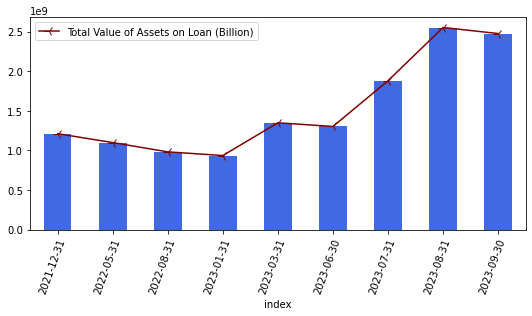

In [48]:
arc.index = arc['index']
new_guys = arc[arc['originationDate'] > '2020-01-01']
new_guys['originationDate'].sort_values();
st = [] 
for x in new_guys['reportingPeriodEndingDate'].sort_values():
    x = str(x)[:10]
    if x not in set(st):
        st.append(x)
lis_dates = st[1:] # WE have all contracts with origination dayes '2020-02-01' and after
file_dates = []
exposures = []
for date in lis_dates:
    final = new_guys[new_guys['reportingPeriodEndingDate']<=date]
    most_current_filings = final.drop_duplicates('assetNumber',keep='first') # Dropping less recent updates
    actives = most_current_filings[most_current_filings['zeroBalanceEffectiveDate'].isnull()] # Filtering for only active loans
    asset_exposure = sum(actives['vehicleValueAmount'])
    print(f'Total Asset Exposure for {date} is ${asset_exposure}')
    exposures.append(asset_exposure)
    file_dates.append(first_file_date)
exposure_df = pd.DataFrame(data = exposures, index = lis_dates)
exposure_df.reset_index(inplace=True)
lis_dates = file_dates
exposure_df.index = exposure_df[exposure_df.columns[0]]
# YOU CAN FILTER BY ORGINATION DATE
import pandas as pd
import matplotlib.pyplot as plt
n_unique_dates = len(lis_dates)
fig = plt.figure(figsize=(n_unique_dates/5, n_unique_dates/10))
plt.rcParams["figure.figsize"] = [7.50, 4.50]
plt.rcParams["figure.autolayout"] = True
fig, ax = plt.subplots()
exposure_df[exposure_df.columns[1]].plot(kind='bar', color='royalblue')
exposure_df[exposure_df.columns[1]].plot(kind='line', marker='3', color='maroon', ms=10)
ax.set_xticklabels(labels=exposure_df.index, rotation=70, rotation_mode="anchor", ha="right")
ax.legend(labels=['Total Value of Assets on Loan (Billion)']);
plt.show()